In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

pd.options.display.max_columns = 500

In [2]:
df_train = pd.read_csv('train_data_nonull.csv')
df_val = pd.read_csv('val_data_nonull.csv')

In [3]:
keys = ['id', 'vintage']
product = ['installments']
relevance_features = ['is_loan', 'is_default', 'relevance_score']
hold_feature = ['internal_feature_3']

all_remaining = [col for col in df_train.columns if col not in keys + product + relevance_features + hold_feature]

Treatment for categorical features

In [4]:
def get_regiao(value):
    if value in ['RS', 'PR', 'SC']:
        new_value = 'Sul'
    elif value in ['MG', 'RJ', 'ES']:
        new_value = 'Sudeste'
    elif value in ['MS', 'MT', 'GO', 'DF']:
        new_value = 'Centro_Oeste'
    elif value in ['BA', 'PI', 'MA', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE']:
        new_value = 'Nordeste'
    elif value in ['AC', 'RO', 'AM', 'AP', 'PA', 'RR', 'TO']:
        new_value = 'Norte'
    else:
        new_value = 'SP'
    return new_value

df_train['internal_feature_11'] = df_train['internal_feature_11'].apply(lambda x: get_regiao(x))
df_val['internal_feature_11'] = df_val['internal_feature_11'].apply(lambda x: get_regiao(x))

In [5]:
trans_dict = {}

for feature in ['internal_feature_0', 'internal_feature_4']:

    temp = df_train[feature] \
            .value_counts(normalize = True) \
            .sort_values(ascending = False) \
            .reset_index() \
            .rename(columns = {'index': feature, feature: 'values'})

    temp['values'] = temp.apply(lambda x: x[0] if x[1] > 0.01 else 'Others', axis = 1)

    temp_dict = {}
    for line in temp[feature]:        
        temp_dict[line] = temp.loc[temp[feature] == line, 'values'].values[0]
    
    trans_dict[feature] = temp_dict
    
for feature in trans_dict.keys():
    df_train[feature] = df_train[feature].apply(lambda x: trans_dict[feature][x])

In [6]:
def transform_if5(value):
    if value in ['IEMP', 'BUSI']:
        return 'BUSINESS'
    elif value in ['DEBT', 'PCRE', 'PDEB', 'PEMP', 'PDIV', 'PORT']:
        return 'DEBT'
    elif value in ['VEIC', 'ELET']:
        return 'PURCHASE'
    elif value in ['IMOB', 'FURN']:
        return 'HOUSE'
    elif value in ['ESTH', 'MEDI']:
        return 'MEDICAL'
    else:
        return 'OTHERS'

df_train['internal_feature_5'] = df_train['internal_feature_5'].apply(lambda x: transform_if5(x))
df_val['internal_feature_5'] = df_val['internal_feature_5'].apply(lambda x: transform_if5(x))

In [7]:
# internal_feature_9

def get_status(value):
    if value in ['DIVORCED', 'SEPARATED']:
        new_value = 'DIVORCED'
    elif value in ['MARRIED', 'STABLE_UNION']:
        new_value = 'MARRIED'
    else:
        new_value = 'SINGLE'
    return new_value

df_train['internal_feature_9'] = df_train['internal_feature_9'].apply(lambda x: get_status(x))
df_val['internal_feature_9'] = df_val['internal_feature_9'].apply(lambda x: get_status(x))

In [8]:
bureau_cat = ['bureau_feature_16', 'bureau_feature_17', 'bureau_feature_18', 
              'bureau_feature_19', 'bureau_feature_20', 'bureau_feature_21']

for feature in bureau_cat:
    df_train[feature] = df_train[feature].apply(lambda x: 'NAO_CONSTAM_OCORRENCIAS' if x == 'Not_found' else x)
    df_val[feature] = df_val[feature].apply(lambda x: 'NAO_CONSTAM_OCORRENCIAS' if x == 'Not_found' else x)

Treatment for numerical columns

In [9]:
# Define %
def concentration(database):
    Numerical_variables = database.select_dtypes(include=['float64', 'int64'])
    to_remove = []
    for var in list(Numerical_variables):
        value_counts = database[var].value_counts(normalize=True)
        if len(list(value_counts[value_counts > 0.70])) > 0:
            to_remove.append(var)
    return to_remove

In [10]:
drop = concentration(df_train)

In [11]:
drop_variables_numeric = ['bacen_feature_0', 'bacen_feature_4', 'bacen_feature_5', 'bacen_feature_7', 'bacen_feature_8', 'bacen_feature_9', 'bacen_feature_10', 'bacen_feature_12', 'bacen_feature_13', 'bacen_feature_14', 'bacen_feature_15', 'bacen_feature_17', 'bureau_feature_1', 'bureau_feature_2', 'bureau_feature_3', 'bureau_feature_5', 'bureau_feature_6', 'bureau_feature_7', 'bureau_feature_9', 'bureau_feature_11', 'bureau_feature_12', 'bureau_feature_13', 'bureau_feature_14']

In [12]:
df_train = df_train.drop(drop_variables_numeric, axis = 1)
df_val = df_val.drop(drop_variables_numeric, axis = 1)

Feature correlation

In [13]:
all_remaining = [col for col in df_train.columns if col not in keys + product + relevance_features + hold_feature]

In [14]:
# Linear correlation
df_train[all_remaining].corr()

,internal_feature_1,internal_feature_2,internal_feature_6,internal_feature_7,internal_feature_8,bacen_feature_1,bacen_feature_2,bacen_feature_3,bacen_feature_6,bacen_feature_11,bacen_feature_16,bureau_feature_4,bureau_feature_15
internal_feature_1,1.000000,0.191468,0.055585,0.557629,0.201776,0.421638,0.155442,0.219942,0.285260,0.528229,0.416990,0.025560,0.071068
internal_feature_2,0.191468,1.000000,0.006175,0.247845,0.089901,0.177916,0.055853,0.165060,0.140632,0.241950,0.261975,0.039348,-0.018639
internal_feature_6,0.055585,0.006175,1.000000,0.007896,0.007382,0.007848,0.005001,-0.004053,0.017186,0.008530,0.021668,-0.025175,-0.020278
internal_feature_7,0.557629,0.247845,0.007896,1.000000,0.160172,0.807118,0.236981,0.424190,0.393566,0.983526,0.281889,0.059078,0.083817
internal_feature_8,0.201776,0.089901,0.007382,0.160172,1.000000,0.103412,0.058035,0.113376,0.077943,0.153337,0.136573,-0.062338,-0.019071
bacen_feature_1,0.421638,0.177916,0.007848,0.807118,0.103412,1.000000,0.079292,0.158978,0.168821,0.819497,0.241519,0.051277,0.080227
bacen_feature_2,0.155442,0.055853,0.005001,0.236981,0.058035,0.079292,1.000000,0.105794,0.121523,0.242645,0.119229,0.039250,0.036233
bacen_feature_3,0.219942,0.165060,-0.004053,0.424190,0.113376,0.158978,0.105794,1.000000,0.105343,0.433202,0.126824,0.036893,0.049969
bacen_feature_6,0.285260,0.140632,0.017186,0.393566,0.077943,0.168821,0.121523,0.105343,1.000000,0.401493,0.219279,0.032796,0.033631
bacen_feature_11,0.528229,0.241950,0.008530,0.983526,0.153337,0.819497,0.242645,0.433202,0.401493,1.000000,0.290773,0.075403,0.097442


In [15]:
drop_linear = ['bacen_feature_1']

In [16]:
# Ranking correlation
df_train[all_remaining].corr('spearman')

,internal_feature_1,internal_feature_2,internal_feature_6,internal_feature_7,internal_feature_8,bacen_feature_1,bacen_feature_2,bacen_feature_3,bacen_feature_6,bacen_feature_11,bacen_feature_16,bureau_feature_4,bureau_feature_15
internal_feature_1,1.000000,0.317839,0.347806,0.390175,0.268299,0.232680,0.120631,0.119554,0.172753,0.354173,0.339553,0.010230,0.038807
internal_feature_2,0.317839,1.000000,0.223081,0.345975,0.132803,0.227150,0.123349,0.182059,0.206836,0.326509,0.502169,0.058337,0.026818
internal_feature_6,0.347806,0.223081,1.000000,0.125396,0.071731,0.064332,0.053152,0.008150,0.085158,0.130975,0.291557,0.099647,0.106376
internal_feature_7,0.390175,0.345975,0.125396,1.000000,0.154143,0.656162,0.332353,0.455132,0.430623,0.937143,0.339876,0.069452,0.088620
internal_feature_8,0.268299,0.132803,0.071731,0.154143,1.000000,0.085311,0.059398,0.084051,0.027809,0.130879,0.121443,-0.081978,-0.056794
bacen_feature_1,0.232680,0.227150,0.064332,0.656162,0.085311,1.000000,0.132202,0.182371,0.199690,0.682431,0.260187,0.075953,0.091900
bacen_feature_2,0.120631,0.123349,0.053152,0.332353,0.059398,0.132202,1.000000,0.297430,0.192077,0.374019,0.252239,0.037932,0.043608
bacen_feature_3,0.119554,0.182059,0.008150,0.455132,0.084051,0.182371,0.297430,1.000000,0.152682,0.489287,0.221994,0.067328,0.073853
bacen_feature_6,0.172753,0.206836,0.085158,0.430623,0.027809,0.199690,0.192077,0.152682,1.000000,0.474432,0.340495,0.059256,0.060100
bacen_feature_11,0.354173,0.326509,0.130975,0.937143,0.130879,0.682431,0.374019,0.489287,0.474432,1.000000,0.420425,0.130154,0.145788


In [17]:
drop_ranking = ['bacen_feature_11']

drop_total = drop_linear + drop_ranking

In [18]:
df_train.drop(columns = drop_total, inplace = True)
df_val.drop(columns = drop_total, inplace = True)

Outlier Treatment

In [19]:
all_remaining = [col for col in df_train.columns if col not in keys + product + relevance_features + hold_feature]

In [20]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

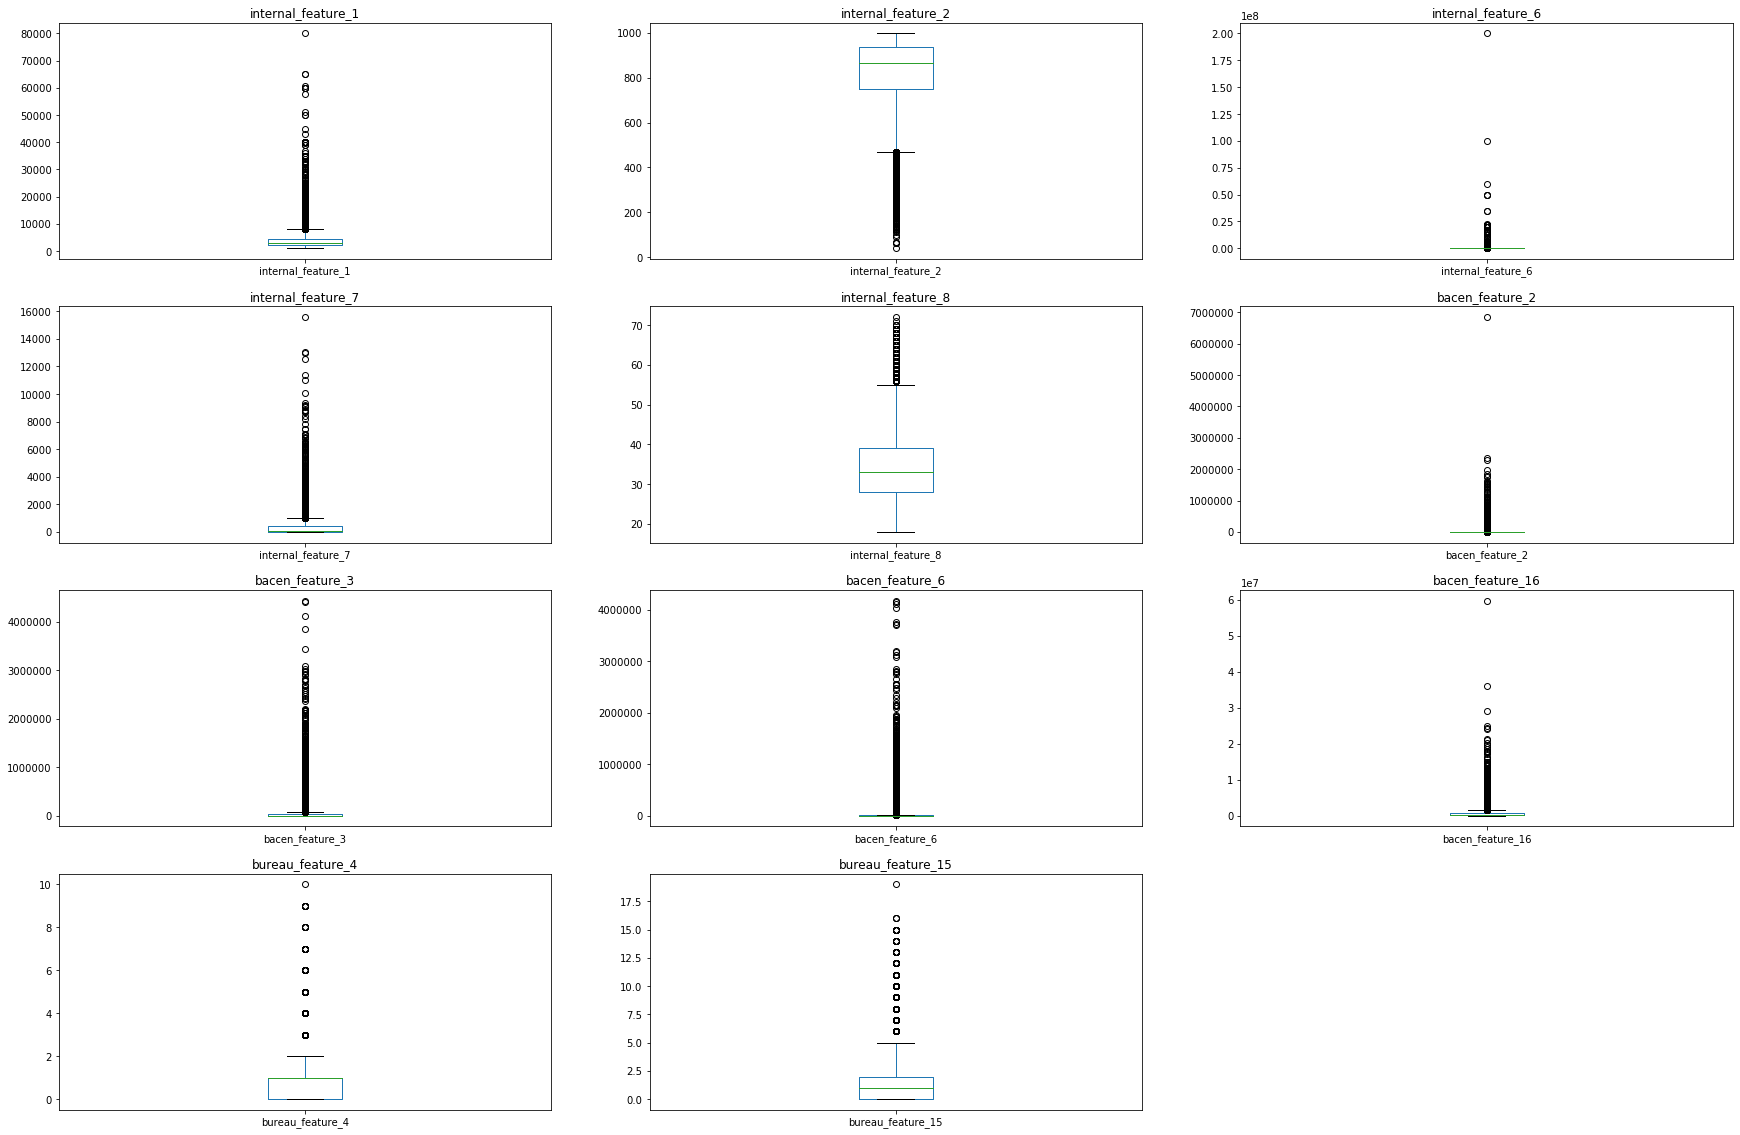

In [21]:
fig, ax = plt.subplots(4, 3, figsize = (30, 20))

i = 0
j = 0

for col in df_train[all_remaining].select_dtypes(include=['float64', 'int64']).columns:
    df_train[col].plot.box(title = col, ax = ax[i,j])
    if j < 2:
        j += 1
    else:
        i += 1
        j = 0
        
trim_axs(ax, 11)

plt.show()

In [24]:
treat_internal_outlier = ['internal_feature_1', 'internal_feature_6', 'internal_feature_7']
treat_external_outlier = ['bacen_feature_2', 'bacen_feature_3', 'bacen_feature_6', 'bacen_feature_16']
treat_outlier = treat_internal_outlier + treat_external_outlier

treat_dict = {}

for feature in treat_internal_outlier:
    treat_dict[feature] = df_train[feature].quantile(0.99)
    
for feature in treat_external_outlier:
    treat_dict[feature] = df_train[feature].quantile(0.95)

In [25]:
for feature in treat_outlier:
    df_train[feature] = df_train[feature].apply(lambda x: x if x < treat_dict[feature] else treat_dict[feature])
    df_val[feature] = df_val[feature].apply(lambda x: x if x < treat_dict[feature] else treat_dict[feature])

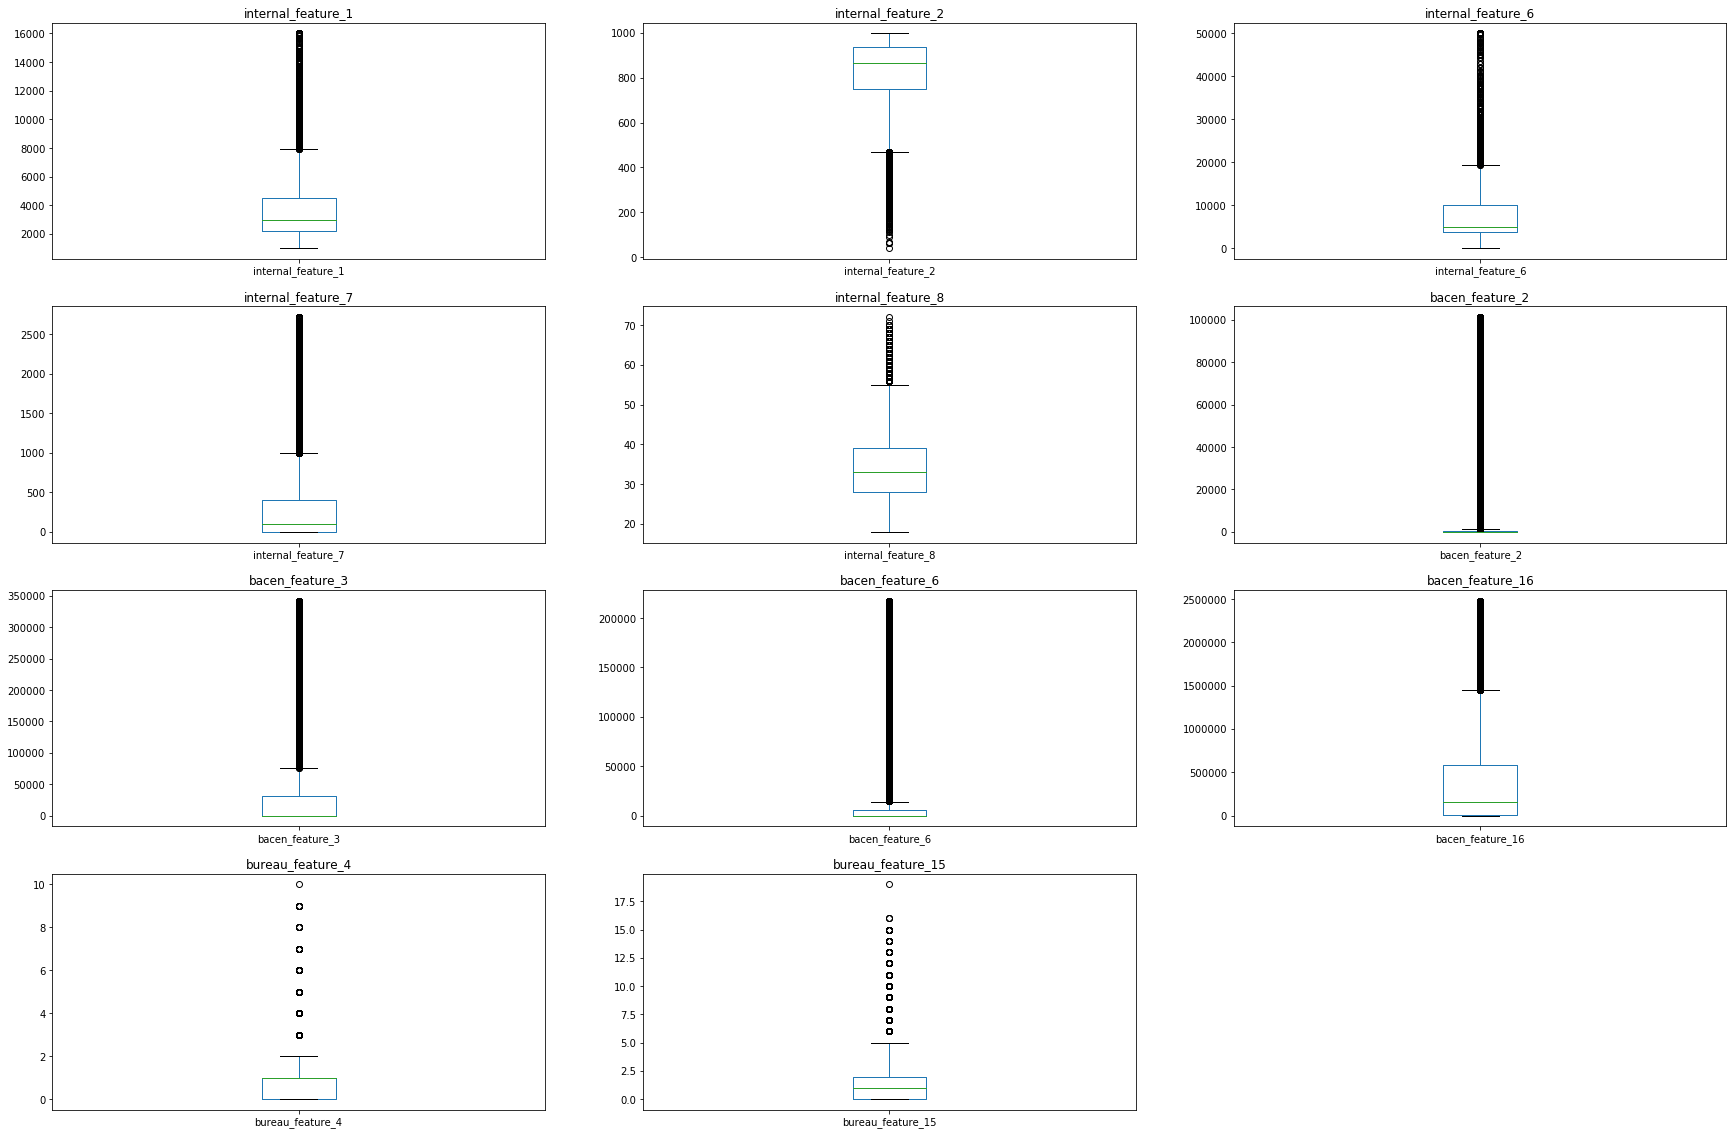

In [26]:
fig, ax = plt.subplots(4, 3, figsize = (30, 20))

i = 0
j = 0

for col in df_train[all_remaining].select_dtypes(include=['float64', 'int64']).columns:
    df_train[col].plot.box(title = col, ax = ax[i,j])
    if j < 2:
        j += 1
    else:
        i += 1
        j = 0
        
trim_axs(ax, 11)

plt.show()

Transform scale

In [28]:
num_feats = df_train[all_remaining].select_dtypes(include=['float64', 'int64']).columns

scaler = MinMaxScaler().fit(df_train[num_feats])

df_train[num_feats] = scaler.transform(df_train[num_feats])
df_val[num_feats] = scaler.transform(df_val[num_feats])

In [30]:
df_train.to_csv('train_data_final.csv', index = False)
df_val.to_csv('val_data_final.csv', index = False)